In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import numpy.random
os.chdir('/Users/cody/Documents/GitHub/DSCI235-Project/235_Project')

# Non-Goalie (Skater) Data

In [216]:
non_goal = pd.read_csv('Non_goalie_data.csv')

In [217]:
non_goal.head()

,Player,Age,Tm,GP,CF,CA,CF%,CF% rel,FF,FA,...,TOI(EV),TK,GV,E+/-,SAtt.,Thru%,F,D,C,W
0,Justin Abdelkader,31.0,DET,71,782,918,46.0,-2.8,571,716,...,12:54,9,40,-11.0,159.0,59.7,0,0,0,1
1,Pontus Åberg,25.0,TOT,59,722,681,51.5,3.3,521,525,...,12:31,15,36,-0.3,NaN,NaN,0,0,0,1
2,Pontus Åberg,25.0,ANA,37,511,449,53.2,7.4,360,351,...,13:32,13,31,-0.4,153.0,48.4,0,0,0,1
3,Pontus Åberg,25.0,MIN,22,211,232,47.6,-4.1,161,174,...,10:48,2,5,0.1,58.0,46.6,0,0,0,1
4,Vitaly Abramov,20.0,OTT,1,9,13,40.9,-1.8,4,9,...,13:01,4,2,-0.8,5.0,0.0,0,0,0,1


## Removed Forwards 

Forwards are a general term for each of Centers(C) and Left/Right Wingers(W)

In [218]:
non_goal = non_goal[['Age', 'CF%', 'D', 'C', 'W']]

In [219]:
non_goal.head()

,Age,CF%,D,C,W
0,31.0,46.0,0,0,1
1,25.0,51.5,0,0,1
2,25.0,53.2,0,0,1
3,25.0,47.6,0,0,1
4,20.0,40.9,0,0,1


In [220]:
defender = non_goal[(non_goal['D'] == 1)]
defender = defender.dropna()
defender.head()

,Age,CF%,D,C,W
11,27.0,53.1,1,0,0
12,30.0,51.8,1,0,0
18,22.0,51.4,1,0,0
40,28.0,40.6,1,0,0
42,27.0,53.0,1,0,0


In [221]:
x_d = defender['Age'].values
y_d = defender['CF%'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

In [222]:
lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 100
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

In [223]:
y_boots.shape

(100, 2242)

In [224]:
std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

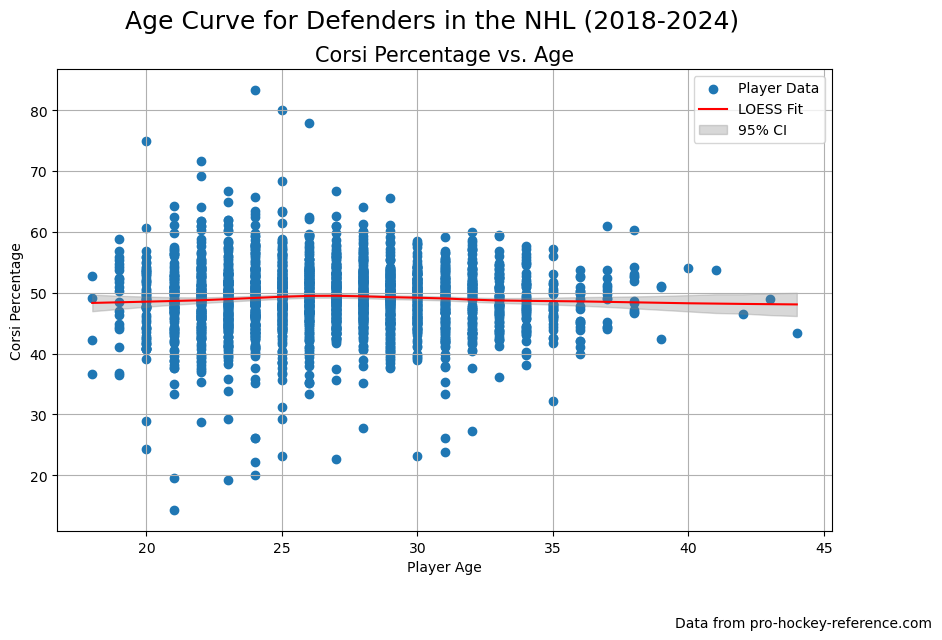

In [225]:
plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

### Normalize Y Axis

In [226]:
defender.head()

,Age,CF%,D,C,W
11,27.0,53.1,1,0,0
12,30.0,51.8,1,0,0
18,22.0,51.4,1,0,0
40,28.0,40.6,1,0,0
42,27.0,53.0,1,0,0


In [227]:
std = np.std(defender['CF%'])
mean = np.mean(defender['CF%'])
print('Mean:', mean)
print('Standard Deviation:', std)

Mean: 48.95423728813559
Standard Deviation: 5.628858860564118


In [228]:
defender['diff'] = defender['CF%'] - mean
defender.head()

,Age,CF%,D,C,W,diff
11,27.0,53.1,1,0,0,4.145763
12,30.0,51.8,1,0,0,2.845763
18,22.0,51.4,1,0,0,2.445763
40,28.0,40.6,1,0,0,-8.354237
42,27.0,53.0,1,0,0,4.045763


In [229]:
defender['Normalized CF%'] = defender['diff'] / std
defender.head()

,Age,CF%,D,C,W,diff,Normalized CF%
11,27.0,53.1,1,0,0,4.145763,0.736519
12,30.0,51.8,1,0,0,2.845763,0.505567
18,22.0,51.4,1,0,0,2.445763,0.434504
40,28.0,40.6,1,0,0,-8.354237,-1.484180
42,27.0,53.0,1,0,0,4.045763,0.718754


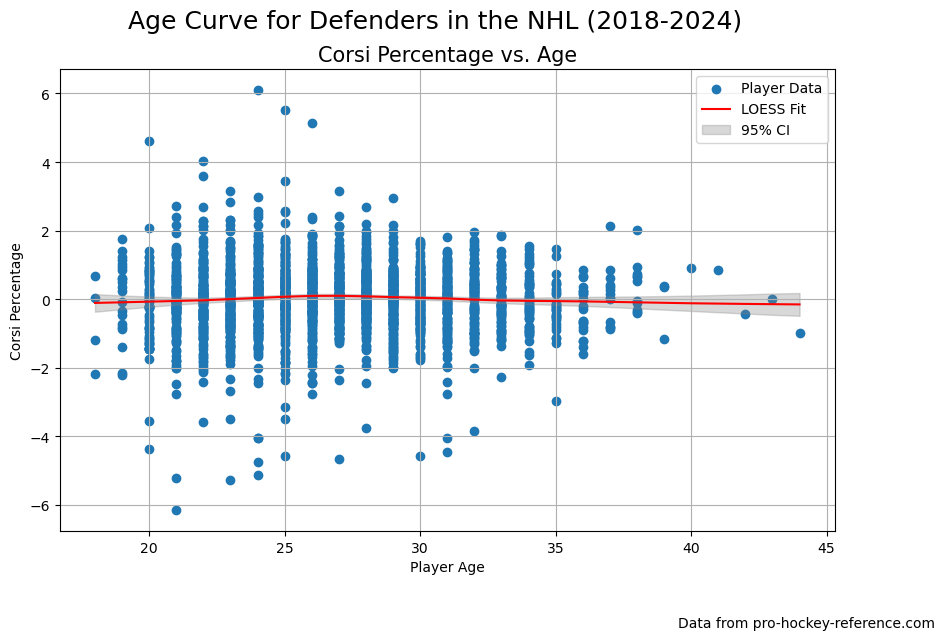

In [230]:
x_d = defender['Age'].values
y_d = defender['Normalized CF%'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std



plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

# Defenders

In [231]:
non_goal = pd.read_csv('Non_goalie_data.csv')
non_goal = non_goal[['Age','GP', 'TK', 'D', 'CF% rel']]
defender = non_goal[(non_goal['D'] == 1)]
defender = defender.dropna()
defender.head()

,Age,GP,TK,D,CF% rel
11,27.0,2,0,1,8.4
12,30.0,9,1,1,-3.5
18,22.0,79,24,1,-3.0
40,28.0,12,3,1,-11.8
42,27.0,78,28,1,4.5


## Takeaways
The player takes the puck from the opposition, rather than gaining possession through opposition error

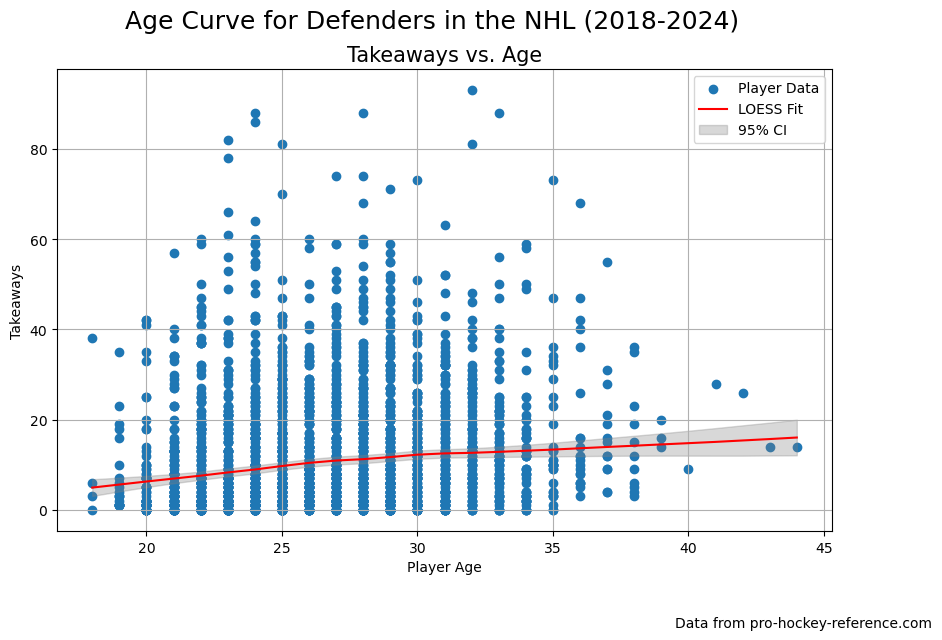

In [232]:
x_d = defender['Age'].values
y_d = defender['TK'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Takeaways vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Takeaways')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)
plt.legend();

## Relative Corsi Percentage
#### Relative Corsi Percentage: On Ice Corsi For % - Off Ice Corsi For %

Corsi For Percentage: Corsi For / Corsi Against

Corsi For: Number of Shot Attempts by the player's team

Corsi Against: Number of Shot Attempts against the player's team

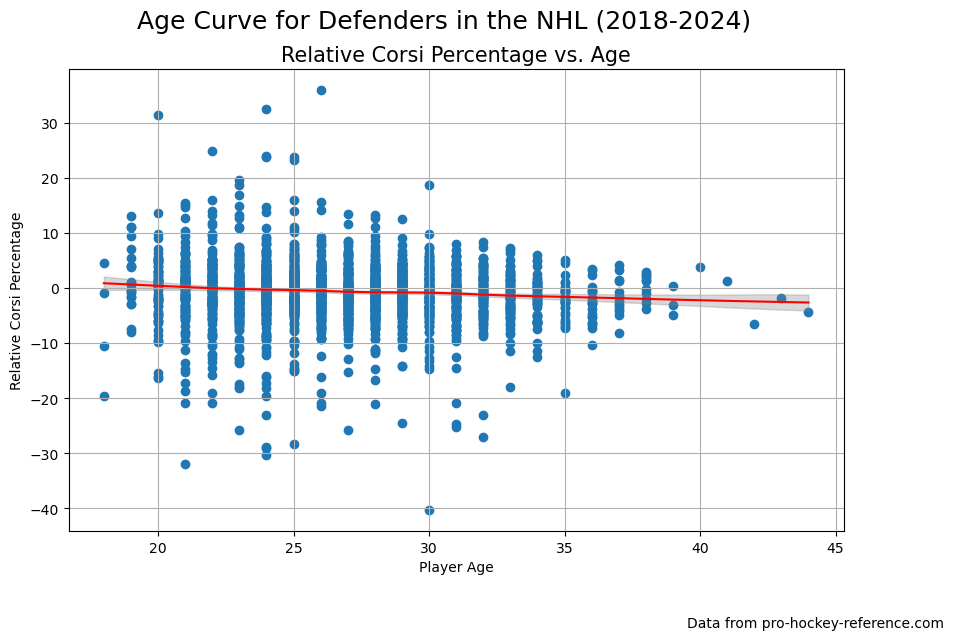

In [233]:
x_d = defender['Age'].values
y_d = defender['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Defenders in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)

# Wingers

In [234]:
non_goal = pd.read_csv('Non_goalie_data.csv')
non_goal = non_goal[['Age','GP', 'Thru%', 'W', 'CF% rel']]
winger = non_goal[(non_goal['W'] == 1)]
winger = winger.dropna()
winger.head()

,Age,GP,Thru%,W,CF% rel
0,31.0,71,59.7,1,-2.8
2,25.0,37,48.4,1,7.4
3,25.0,22,46.6,1,-4.1
4,20.0,1,0.0,1,-1.8
7,26.0,36,55.1,1,3.5


## Relative Corsi Percentage

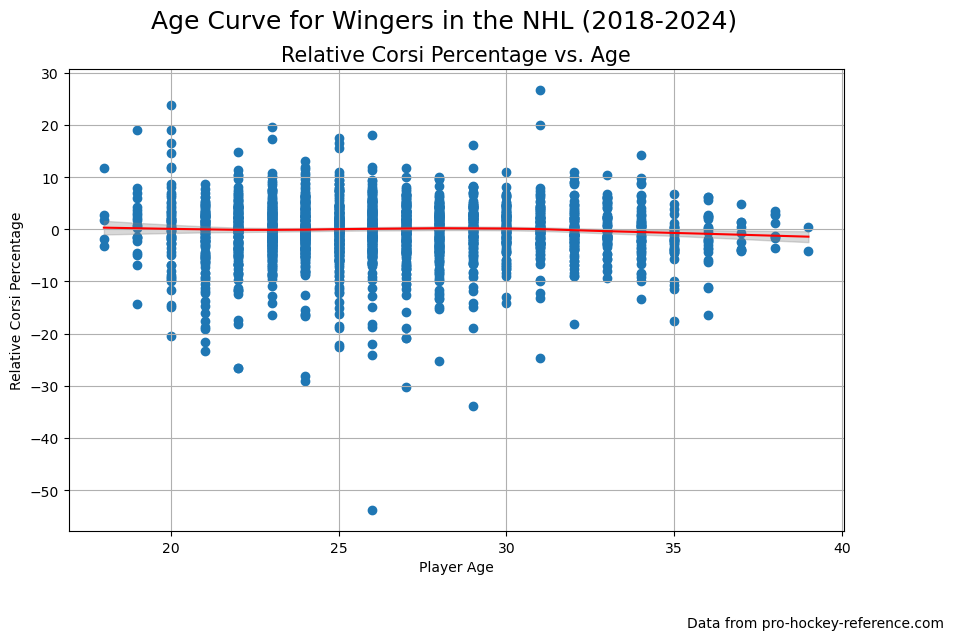

In [235]:
x_d = winger['Age'].values
y_d = winger['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Wingers in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)

# Centers

In [236]:
non_goal = pd.read_csv('Non_goalie_data.csv')
non_goal = non_goal[['Age','GP', 'Thru%', 'C', 'CF% rel']]
center = non_goal[(non_goal['C'] == 1)]
center = center.dropna()
center.head()

,Age,GP,Thru%,C,CF% rel
5,27.0,72,62.3,1,-4.1
10,21.0,82,52.1,1,3.4
13,22.0,43,44.6,1,2.0
16,19.0,5,60.0,1,-8.6
17,20.0,42,65.1,1,-3.1


## Relative Corsi Percentage

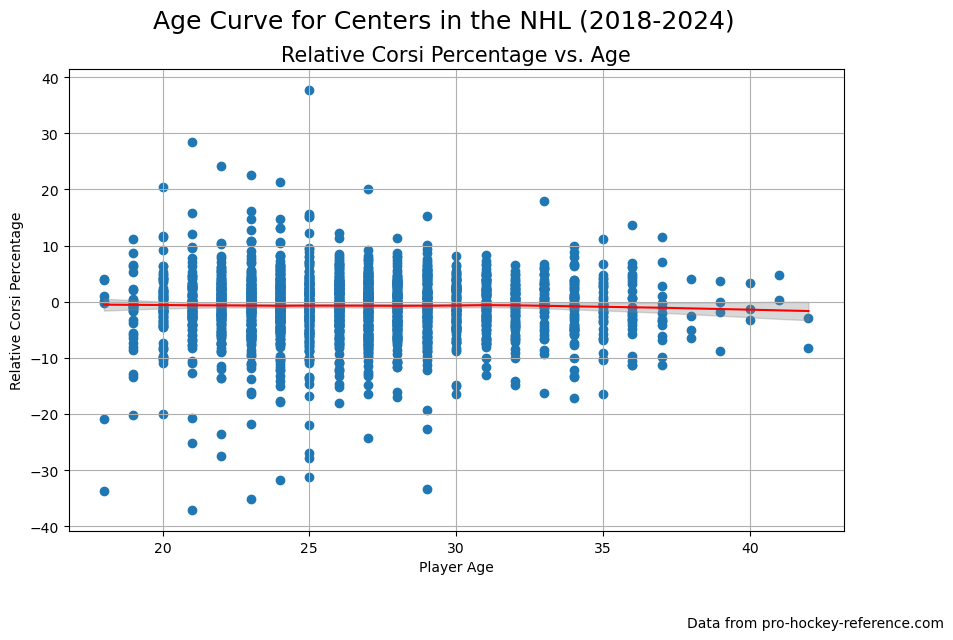

In [237]:
x_d = center['Age'].values
y_d = center['CF% rel'].values
index = np.argsort(x_d)
x_d = x_d[index]
y_d = y_d[index]

lowess = sm.nonparametric.lowess
loess_result = lowess(y_d, x_d, frac=0.5, return_sorted=True)
xd_fit = loess_result[:, 0]
yd_fit = loess_result[:, 1]

n_boot = 1000
y_boots = np.full((n_boot, len(xd_fit)), np.nan)

for i in range(n_boot):
    sample_idx = np.random.choice(len(x_d), size=len(x_d), replace=True)
    y_sample = y_d[sample_idx]
    x_sample = x_d[sample_idx]
    
    loess_boot = lowess(y_sample, x_sample, frac=0.5, return_sorted=True)
    y_b = loess_boot[:,1]
    x_b = loess_boot[:,0]

    interp = np.interp(xd_fit, x_b, y_b, left=np.nan, right=np.nan)
    y_boots[i, :] = interp

std = np.nanstd(y_boots, axis=0)
upper_band = yd_fit + 1.96 * std
lower_band = yd_fit - 1.96 * std

plt.figure(figsize=(10,6))
plt.scatter(x_d,y_d, label='Player Data')
plt.plot(xd_fit,yd_fit, color='red', label='LOESS Fit')
plt.fill_between(xd_fit, lower_band, upper_band, color='gray', alpha=0.3, label='95% CI')
plt.suptitle("Age Curve for Centers in the NHL (2018-2024)", fontsize=18)
plt.title('Relative Corsi Percentage vs. Age', fontsize=15)
plt.xlabel('Player Age')
plt.ylabel('Relative Corsi Percentage')
plt.figtext(1,-0.05,"Data from pro-hockey-reference.com", ha='right')
plt.grid(True)